In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np
import math

In [2]:
#pip install yfinance

# Get stock's data using Yahoo's Finance API

In [3]:


import yfinance as yf

msft = yf.Ticker("MSFT")

# get stock info
#print(msft.info)

# Downloading the Data 

I am working with the stock market data for SANOFI within the last 10 years. 

In [4]:
tickerSymbol = "SNY"
tickerData = yf.Ticker(tickerSymbol)
df = tickerData.history(period='1d', start='2010-10-1', end="2020-9-6")

# Import dataframe Mongodb

In [5]:
from pymongo import MongoClient

In [6]:
myclient = MongoClient("mongodb://localhost:27017/")
mydb = myclient["trading_SANOFI"]
mycol1 = mydb["API_stocks"]
mycol2 = mydb["API_articles"]


In [7]:
df.reset_index(inplace=True)
data_dict = df.to_dict("records")
mycol1.insert_one({"index":"SYN","data":data_dict})



# Data Visualization

**Open**: Opening stock price of the day 

**Close**: Closing stock price of the day

**High**: Highest stock price of the data

**Low**: Lowest stock price of the day

In [8]:
df = df.drop("Stock Splits", axis=1)

In [9]:
df.to_csv("history_stock_Sanofi.csv")

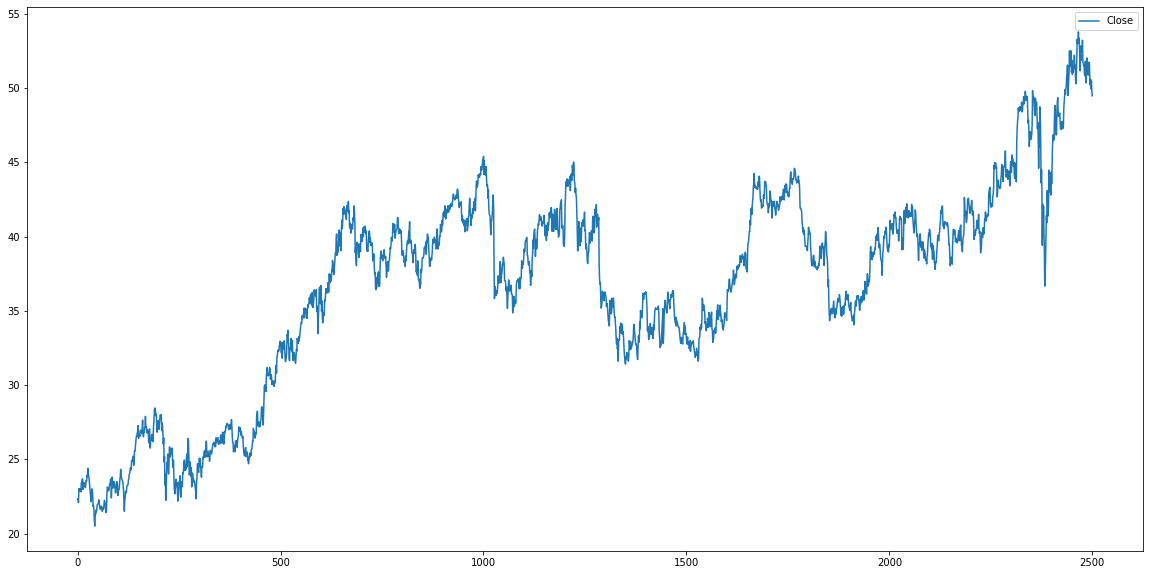

In [10]:
plt.figure(figsize = (20,10))
plt.plot(df['Close'], label = 'Close')
plt.legend(loc='best')
plt.show()

I create a new dataframe with only the 'Close' column

In [11]:
df = df.Close

In [12]:
df.head()

0    22.34
1    22.26
2    22.09
3    23.03
4    22.95
Name: Close, dtype: float64

In [13]:
data = df.values.reshape(-1, 1)

# Préprocessing

## Normalizing

MinMaxScaler scales all the data to be in the region of 0 and 1. 

In [14]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler() 

In [15]:
data_sc= sc.fit_transform(data)
data_sc

array([[0.05502105],
       [0.05261575],
       [0.04750451],
       ...,
       [0.90078172],
       [0.88003608],
       [0.87071557]])

# Splitting Data into a Training and a Test

The goal is to predict  the prices of SANOFI. stock 60 days in the future based on the current Close price.

In [16]:
#train data contains 80% of the data
training_data_len = math.ceil( len(data) *0.8) 
training_data_len

2001

In [17]:
#Create the scaled training data set 
train_data = data_sc[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [18]:
# create Test data set
test_data = data_sc[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  data[training_data_len : , : ] 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [19]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_test = np.array(x_test)

In [20]:
print(x_train.shape)
print(y_train.shape)

(1941, 60)
(1941,)


For the model LSTM, we have to reshape the data to be 3-dimensional in the form [number of samples, number of time steps, and number of features].

In [21]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [22]:
x_train.shape

(1941, 60, 1)

# LSTM 

In [23]:
#pip install notify-run

In [24]:
from notify_run.keras import NotifyCallback

In [25]:
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.models import load_model

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dense(units=1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Train the model
history=model.fit(x_train, y_train, callbacks=[NotifyCallback()], batch_size=1, epochs=15)

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='RMSE')
plt.legend(loc='best')
plt.show()

# Predictions 

In [ ]:
predictions = model.predict(x_test)


In [ ]:
predictions = sc.inverse_transform(predictions)

In [ ]:
predictions = predictions.reshape(-1)

In [ ]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

In [ ]:
train = df[:training_data_len]
predict_test = df[training_data_len:]
data_final = pd.DataFrame(predict_test)
data_final['Predictions'] = predictions
data_final['Company'] = 'SANOFI(SNY)'

In [ ]:
data_final

In [ ]:
#Plot/Create the data for the graph
Actual = data_final.Close
predict = data_final.Predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(Actual)
plt.plot(predict)
plt.legend(['Actual_Price','Predictions'], loc='lower right')
plt.show()

In [ ]:
train

In [ ]:
train = df[:training_data_len]
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train)
plt.plot(data_final[['Close', 'Predictions']])
plt.legend(['Train', 'Actual_value', 'Predictions'], loc='lower right')
plt.show()